In [14]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(argparser))) # command line arguments
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # plot patchwork
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridgeline plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # ggplot2 drawing
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # ggplot2 drawing

source("../../utils/figure_themes.r")


In [15]:
cell_type <- "PBMC"
model_name <- "MultiClass_MLP"

In [16]:
# set file path for importing the data
training_metrics_file <- file.path(paste0(
    "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/training_metrics.parquet"
))
confusion_matrix_file <- file.path(paste0(
    "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/confusion_matrices.parquet"
))
pr_curves_path <- file.path(paste0(
        "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/PR_curves.parquet"
))


# set output file path for graphs
f1_plot_path <- file.path(paste0(
    "../figures/Multi_Class/",model_name,"/",cell_type,"/f1_score.png"
))

confusion_matrix_plot_path <- file.path(paste0(
    "../figures/Multi_Class/",model_name,"/",cell_type,"/confusion_matrix.png"
))

# make the output directory if it doesn't exist
dir.create(file.path(paste0(
    "../figures/Multi_Class/",model_name,"/",cell_type
)), showWarnings = FALSE, recursive = TRUE)



# read in the data
training_metrics <- arrow::read_parquet(training_metrics_file)
confusion_matrix <- arrow::read_parquet(confusion_matrix_file)
PR_curves <- arrow::read_parquet(pr_curves_path)


In [17]:

support <- training_metrics[training_metrics$metric == "support",]
# get apoptosis, healthy, and pyroptosis support rows in one df
support <- support[support$label %in% c("apoptosis", "healthy", "pyroptosis"),]


In [18]:
# get the rows that contain the F1 scores
f1_scores <- training_metrics[training_metrics$metric == "f1-score",]
# remove the rows that contain the macro and weighted averages
f1_scores <- f1_scores[!grepl("macro avg", f1_scores$label),]
f1_scores <- f1_scores[!grepl("weighted avg", f1_scores$label),]
# muatate the label column for multiple cases
f1_scores$label <- gsub("healthy", "Control", f1_scores$label)
f1_scores$label <- gsub("apoptosis", "Apoptosis", f1_scores$label)
f1_scores$label <- gsub("pyroptosis", "Pyroptosis", f1_scores$label)
# mutate the data type column
f1_scores$group <- gsub("train", "Training", f1_scores$group)
f1_scores$group <- gsub("test", "Testing", f1_scores$group)
f1_scores$group <- gsub("validation", "Validation", f1_scores$group)
f1_scores$group <- gsub("treatment_holdout", "Treatment Holdout", f1_scores$group)
f1_scores$group <- gsub("holdout", "Holdout", f1_scores$group)
# factorize the group column
f1_scores$group <- factor(f1_scores$group, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout"
))
# mutate the shuffled_data column
f1_scores$shuffle <- gsub("TRUE", "Shuffled", f1_scores$shuffle)
f1_scores$shuffle <- gsub("FALSE", "Not Shuffled", f1_scores$shuffle)
# cbind the support column to the f1_scores df
f1_scores <- cbind(f1_scores, support$value)
# rename the support column
colnames(f1_scores)[colnames(f1_scores) == "support$value"] <- "support"
# dived the support by 10,000 to get the number of cells
f1_scores$support <- f1_scores$support / 10000
# round the support column to 2 decimal places
f1_scores$support <- round(f1_scores$support, 2)


In [19]:
# make the label a factor so that the order is preserved
f1_scores$label <- factor(
    f1_scores$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )


F1 score  
### $F1 Score = 2 * \frac{precision * recall}{precision + recall}$
### $Precision = \frac{TP}{TP + FP}$
### $Recall = \frac{TP}{TP + FN}$
### $F1 Score = \frac{2 * TP}{2 * TP + FP + FN}$

In [20]:
head(f1_scores, 1)

,label,metric,value,group,shuffle,support
,<fct>,<chr>,<dbl>,<fct>,<chr>,<dbl>
1,Apoptosis,f1-score,0.5917601,Training,Not Shuffled,13.02


In [21]:
# remove the treatment holdout rows
f1_scores <- f1_scores[!grepl("Treatment Holdout", f1_scores$group),]

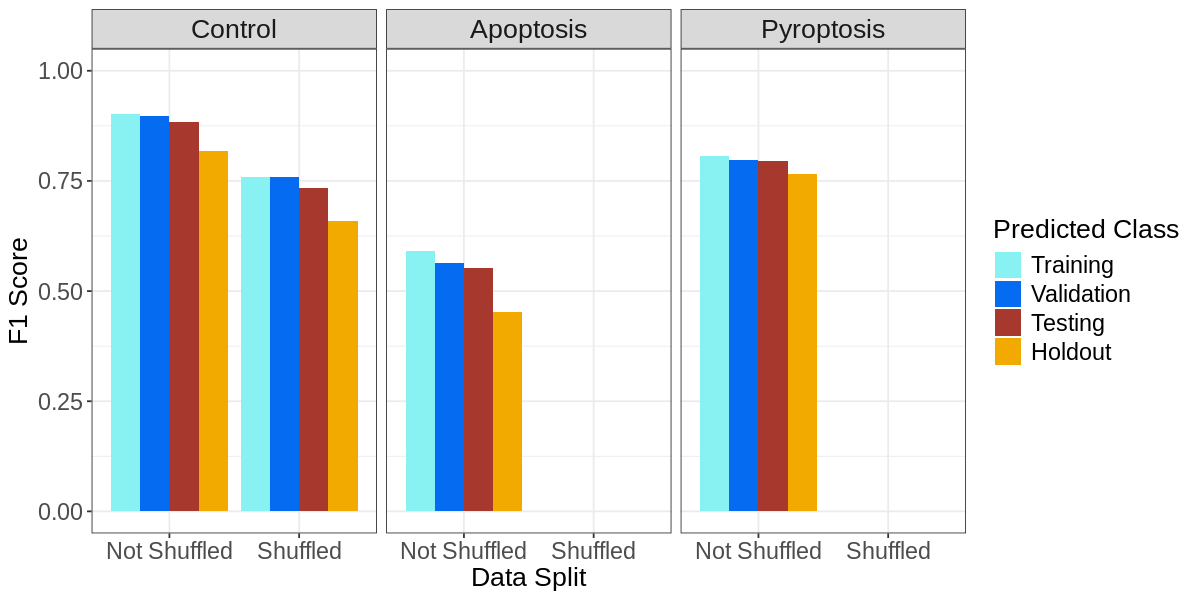

In [22]:
# set plot size
width <- 10
height <- 5
options(repr.plot.width = width, repr.plot.height = height)
# bar plot of the F1 scores
f1_score_plot <- (
    ggplot(f1_scores, aes(x = shuffle, y = value, fill = group))
    + geom_bar(stat = "identity", position = "dodge")

    + ylim(0, 1)
    + facet_wrap(~label)
    + ylab("F1 Score")
    + xlab("Data Split")
    # change the legend title
    + labs(fill = "Predicted Class")
    # change the colours
    + scale_fill_manual(values = c(
        "Training" = "#88F2F2",
        "Validation" = "#056CF2",
        "Testing" = "#A6382E",
        "Holdout" = "#F2A900"
    ))
    + figure_theme_wide

)
ggsave(f1_plot_path, f1_score_plot, width = width, height = height, dpi = 600)
f1_score_plot


## Confusion Matrix data plot

In [23]:
# round the Recall vlaues to 2 decimal places
confusion_matrix$Recall <- round(confusion_matrix$Recall, 2)
# mutate the label column for multiple cases
confusion_matrix$True_Label <- gsub("healthy", "Control", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$True_Label)
confusion_matrix$True_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$True_Label)
confusion_matrix$Predicted_Label <- gsub("healthy", "Control", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("apoptosis", "Apoptosis", confusion_matrix$Predicted_Label)
confusion_matrix$Predicted_Label <- gsub("pyroptosis", "Pyroptosis", confusion_matrix$Predicted_Label)

# make the True Label and Predicted Label columns factors
confusion_matrix$True_Label <- factor(
    confusion_matrix$True_Label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
confusion_matrix$Predicted_Label <- factor(
    confusion_matrix$Predicted_Label, levels = c(
       "Pyroptosis", "Apoptosis", "Control"
        )
    )
    

# mutate the shuffle column
confusion_matrix$shuffle <- gsub("TRUE", "Shuffled", confusion_matrix$shuffle)
confusion_matrix$shuffle <- gsub("FALSE", "Not Shuffled", confusion_matrix$shuffle)
# mutate the data type column
confusion_matrix$data_split <- gsub("testing", "Testing", confusion_matrix$data_split)
confusion_matrix$data_split <- gsub("holdout", "Holdout wells", confusion_matrix$data_split)
# make the data split column a factor
confusion_matrix$data_split <- factor(confusion_matrix$data_split, levels = c(
    "Testing", "Holdout wells"
))
unique(confusion_matrix$data_split)

[1] Testing       Holdout wells
Levels: Testing Holdout wells

In [24]:
# add the , to the count column
confusion_matrix$Count <- sapply(
    confusion_matrix$Count, function(x) format(x, big.mark = ",")
    )

head(confusion_matrix)

True_Label,Predicted_Label,Count,data_split,Recall,shuffle
<fct>,<fct>,<chr>,<fct>,<dbl>,<chr>
Apoptosis,Control,"14,191",Testing,0.01,Not Shuffled
Control,Control,"1,550,186",Testing,0.94,Not Shuffled
Pyroptosis,Control,"90,376",Testing,0.05,Not Shuffled
Apoptosis,Apoptosis,"77,130",Testing,0.47,Not Shuffled
Control,Apoptosis,"52,382",Testing,0.32,Not Shuffled
Pyroptosis,Apoptosis,"33,278",Testing,0.20,Not Shuffled


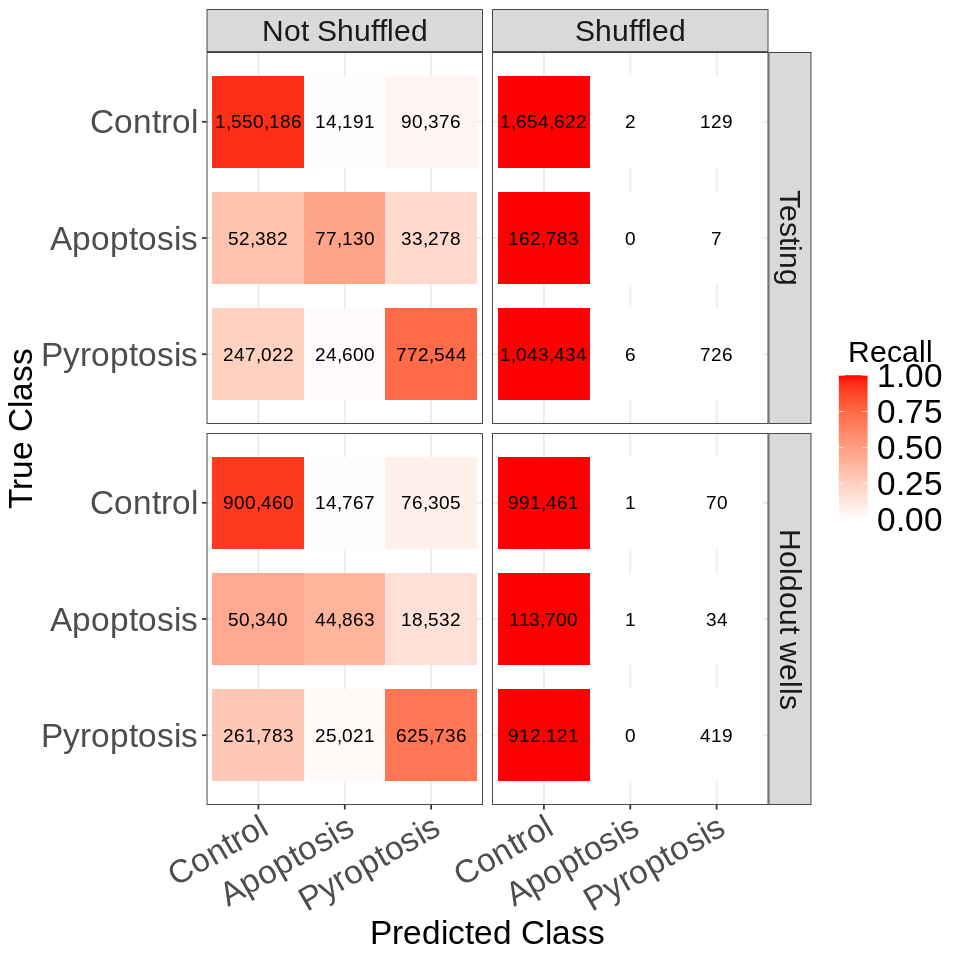

In [25]:
# plot dimensions
width <- 8
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
# plot a confusion matrix
confusion_matrix_plot <- (
    ggplot(confusion_matrix, aes(x = True_Label, y = Predicted_Label))
    + facet_grid(data_split~shuffle)
    + geom_point(aes(color = Recall), size = 25.5, shape = 15)
    + geom_text(aes(label = Count), size = 4)
    + scale_color_gradient("Recall", low = "white", high = "red",limits = c(0, 1))
    + theme_bw()
    + ylab("True Class")
    + xlab("Predicted Class")
    + figure_theme
    # change the legend title position
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 18)
        )
    )
    # make the facet labels larger
    + theme(strip.text = element_text(size = 18))
    # x tick labels 45 degrees
    + theme(axis.text.x = element_text(angle = 30, hjust = 1))


)
ggsave(confusion_matrix_plot_path, confusion_matrix_plot, width = width, height = height, dpi = 600)
confusion_matrix_plot


## PR Curves

In [26]:
# replace strings in pr_curves
PR_curves$label <- gsub("apoptosis", "Apoptosis", PR_curves$label)
PR_curves$label <- gsub("healthy", "Control", PR_curves$label)
PR_curves$label <- gsub("pyroptosis", "Pyroptosis", PR_curves$label)

PR_curves$data_split <- gsub("train", "Training", PR_curves$data_split)
PR_curves$data_split <- gsub("testing", "Testing", PR_curves$data_split)
PR_curves$data_split <- gsub("validation", "Validation", PR_curves$data_split)
PR_curves$data_split <- gsub("treatment_holdout", "Treatment Holdout", PR_curves$data_split)
PR_curves$data_split <- gsub("holdout", "Holdout wells", PR_curves$data_split)

# factorize the data_split column
PR_curves$data_split <- factor(PR_curves$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout wells"
))

unique(PR_curves$label)
unique(PR_curves$data_split)

# replace strings in pr_curves shuffle
PR_curves$shuffle <- gsub("TRUE", "Shuffled", PR_curves$shuffle)
PR_curves$shuffle <- gsub("FALSE", "Not Shuffled", PR_curves$shuffle)

# factorize the shuffled_data column
PR_curves$shuffle <- factor(PR_curves$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))
# class label factor
PR_curves$label <- factor(
    PR_curves$label, levels = c(
        "Control", "Apoptosis", "Pyroptosis"
        )
    )
    
# remove the treatment holdout rows
PR_curves <- PR_curves[!grepl("Treatment Holdout", PR_curves$data_split),]


[1] "Apoptosis"  "Control"    "Pyroptosis"

[1] Training          Validation        Testing           Treatment Holdout
[5] Holdout wells    
Levels: Training Validation Testing Treatment Holdout Holdout wells

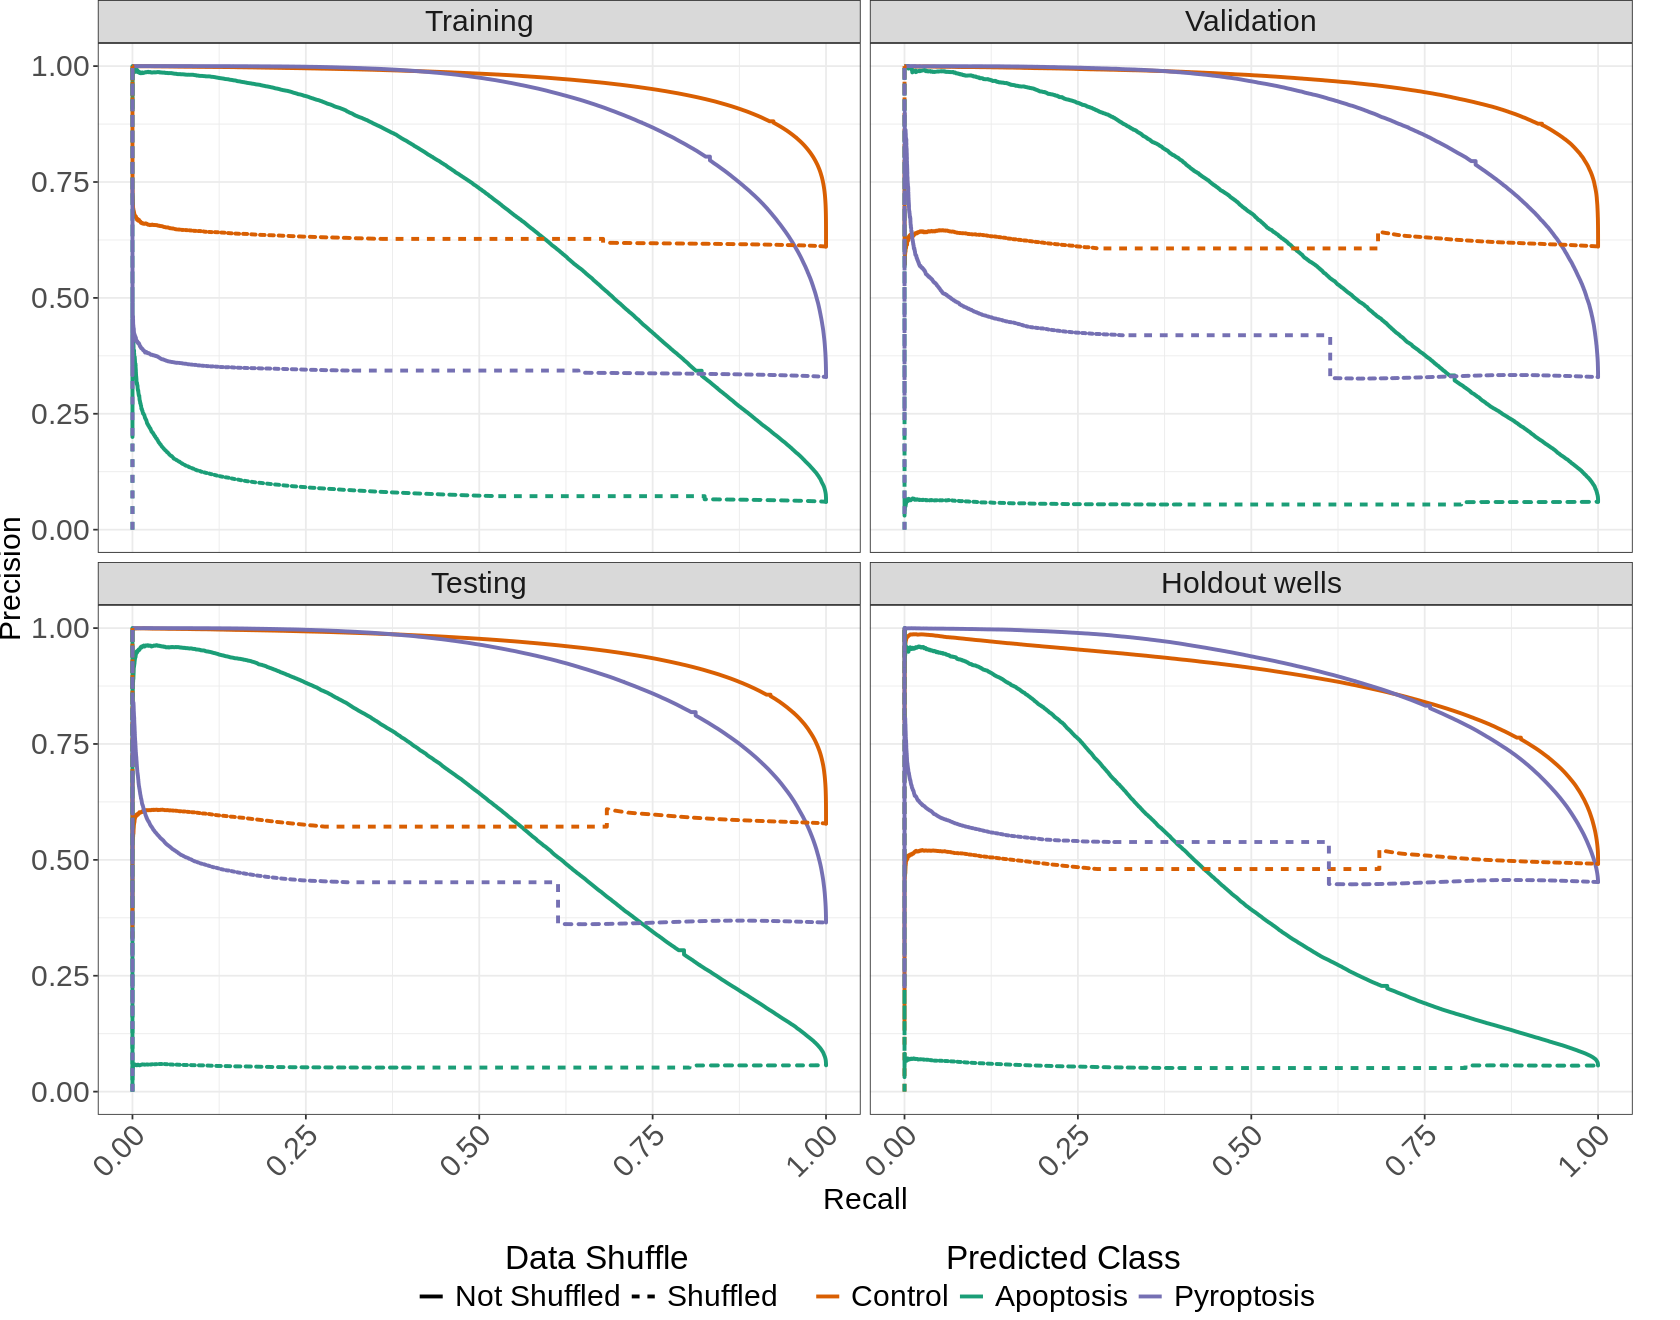

In [27]:
# make a line plot that has the shuffled and not shuffled lines
# with shuffled lines dashed and not shuffled lines solid
# color by label 
width <- 14
height <- 11
options(repr.plot.width = width, repr.plot.height = height)
pr_plot <- (
    ggplot(PR_curves, aes(x = recall, y = precision, color = label, linetype = label))
    + geom_step(aes(linetype = shuffle), linewidth = 1.1)
    # + geom_line(aes(linetype = shuffle), linewidth = 1.1)
    + facet_wrap(~data_split, ncol = 2)
    + theme_bw()
    + labs(color = "Predicted Class", linetype = "Data Shuffle", x = "Recall", y = "Precision")
    # change the colours
    + scale_color_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    # change the line thickness of the lines in the legend
    + guides(linetype = guide_legend(override.aes = list(size = 1)))  
    
    # change the facet text size
    + theme(
        strip.text = element_text(size = 18),
        # x and y axis text size
        axis.text.x = element_text(size = 18),
        axis.text.y = element_text(size = 18),
        # x and y axis title size
        axis.title.x = element_text(size = 18),
        axis.title.y = element_text(size = 18),
        # legend text size
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 18),
    )
    # change the legend position
    + theme(legend.position = "bottom")
    # make the legend horizontal
    + theme(legend.direction = "horizontal")
    + guides(
        linetype = guide_legend(
            order = 1, title.position = "top",
            title.theme = element_text(size = 20, hjust = 0.5)
            ),
        color = guide_legend(
            order = 2, title.position = "top",
            title.theme = element_text(size = 20, hjust = 0.5)
            )
            )
    # rotate the x axis tick labels
    + theme(axis.text.x = element_text(angle = 45, hjust = 1))
    + theme(plot.margin = margin(0,1,0,0, "cm"))
)    
ggsave("../figures/Multi_Class/MultiClass_MLP/PBMC/PR_curves.png", pr_plot, width = width, height = height, dpi = 600)
pr_plot

## Probabilities

In [28]:
# load in the probabilities
treatment_holdout_probabilities_path <- file.path(
    paste0(
        "../../../4.sc_Morphology_Neural_Network_MLP_Model/results/Multi_Class/",model_name,"/",cell_type,"/probabilities.parquet"
    )
)
# read in the data from the parquet file
probabilities <- arrow::read_parquet(
    treatment_holdout_probabilities_path
)
head(probabilities,2)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.057885949,0.7409405,0.2011736,1,1,train,FALSE,healthy,6135062,PBMC,⋯,LPS_Nigericin,1.000_µg_per_ml_10.000_µM,1493.54472,2062.1328,1507,2074,1484,2050,16,pyroptosis
0.003964022,0.4949294,0.5011066,2,2,train,FALSE,pyroptosis,5358238,PBMC,⋯,Thapsigargin,1.000_µM,10.07292,510.1944,20,521,2,501,10,apoptosis


In [29]:
unique(probabilities$data_split)
unique(probabilities$shuffle)

[1] "train"             "validation"        "testing"          
[4] "treatment_holdout" "holdout"

[1] FALSE  TRUE

In [30]:
# remove rows where shuffle is true
probabilities <- probabilities[!grepl("TRUE", probabilities$shuffle),]

In [31]:
# replace label_true value 1 with Control
probabilities$label_true <- gsub("1", "Control", probabilities$label_true)
# replace label_true value 2 with pyroptosis
probabilities$label_true <- gsub("2", "Pyroptosis", probabilities$label_true)
# replace label_true value 0 with apoptosis
probabilities$label_true <- gsub("0", "Apoptosis", probabilities$label_true)

# replace label_pred value 1 with Control
probabilities$label_pred <- gsub("1", "Control", probabilities$label_pred)
# replace label_pred value 2 with pyroptosis
probabilities$label_pred <- gsub("2", "Pyroptosis", probabilities$label_pred)
# replace label_pred value 0 with apoptosis
probabilities$label_pred <- gsub("0", "Apoptosis", probabilities$label_pred)

# replace shuffled value TRUE with Shuffled
probabilities$shuffle <- gsub("TRUE", "Shuffled", probabilities$shuffle)
# replace shuffled value FALSE with Not Shuffled
probabilities$shuffle <- gsub("FALSE", "Not Shuffled", probabilities$shuffle)

# replace data_split value treatment_holdout with Treatment Holdout
probabilities$data_split <- gsub("treatment_holdout", "Treatment Holdout", probabilities$data_split)
# replace data_split value holdout with Holdout
probabilities$data_split <- gsub("holdout", "Holdout wells", probabilities$data_split)
# replace training value train with Training
probabilities$data_split <- gsub("train", "Training", probabilities$data_split)
# replace testing value test with Testing
probabilities$data_split <- gsub("testing", "Testing", probabilities$data_split)
# replace validation value validation with Validation
probabilities$data_split <- gsub("validation", "Validation", probabilities$data_split)


In [32]:
head(probabilities, 2)
unique(probabilities$shuffle)

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Treatment,Metadata_Dose,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,⋯,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.057885949,0.7409405,0.2011736,Control,Control,Training,Not Shuffled,healthy,6135062,PBMC,⋯,LPS_Nigericin,1.000_µg_per_ml_10.000_µM,1493.54472,2062.1328,1507,2074,1484,2050,16,pyroptosis
0.003964022,0.4949294,0.5011066,Pyroptosis,Pyroptosis,Training,Not Shuffled,pyroptosis,5358238,PBMC,⋯,Thapsigargin,1.000_µM,10.07292,510.1944,20,521,2,501,10,apoptosis


[1] "Not Shuffled"

In [33]:
# change the label columns to be factors
probabilities$label_true <- factor(probabilities$label_true , levels = c(
    "Control", "Apoptosis", "Pyroptosis"
))
probabilities$label_pred <- factor(probabilities$label_pred , levels = c(
    "Pyroptosis", "Apoptosis", "Control"
))
# change the data_split column to be a factor
probabilities$data_split <- factor(probabilities$data_split, levels = c(
    "Training", "Validation", "Testing","Treatment Holdout", "Holdout wells"
))
# change the shuffled_data column to be a factor
probabilities$shuffle <- factor(probabilities$shuffle, levels = c(
    "Not Shuffled", "Shuffled"
))

# remove treatment holdout rows
probabilities <- probabilities[!grepl("Treatment Holdout", probabilities$data_split),]

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00765

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0073

Picking joint bandwidth of 0.00799



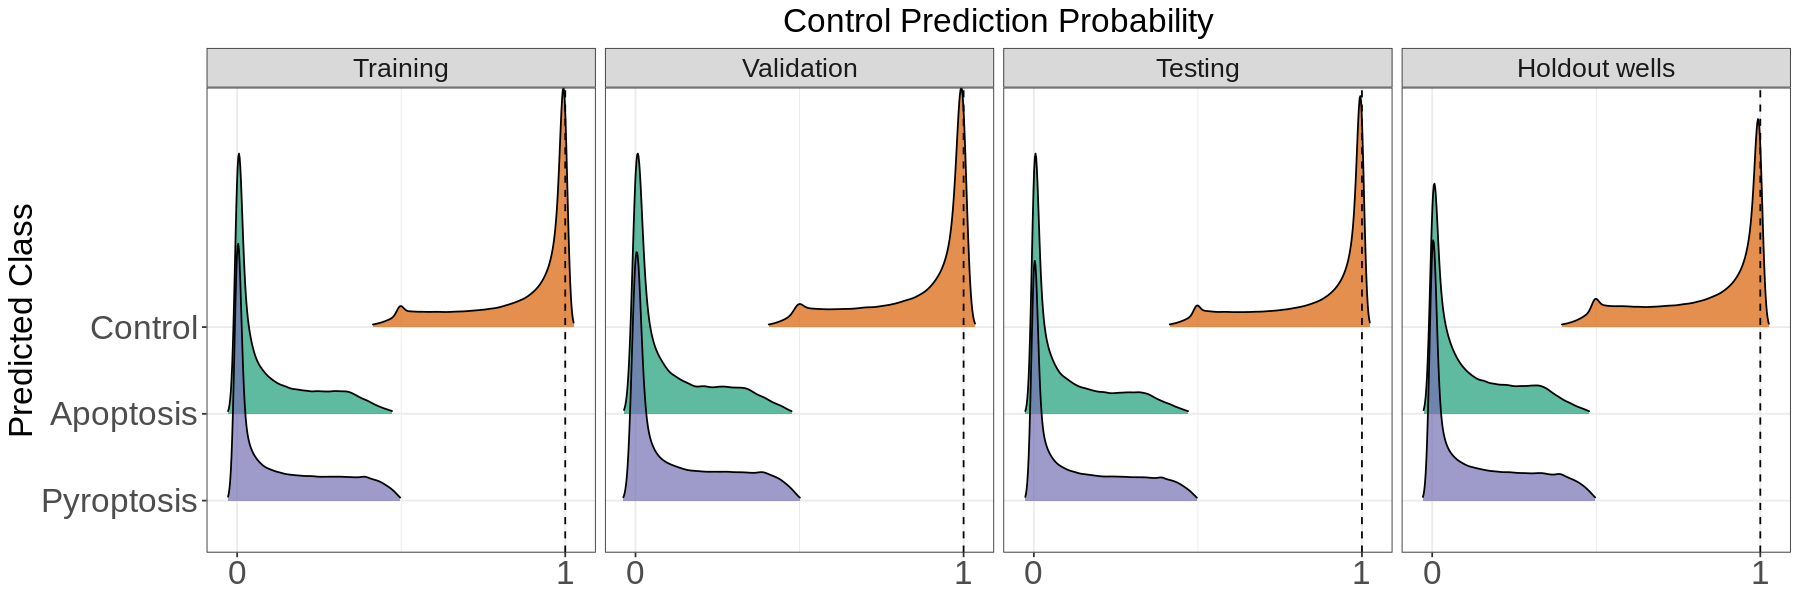

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105



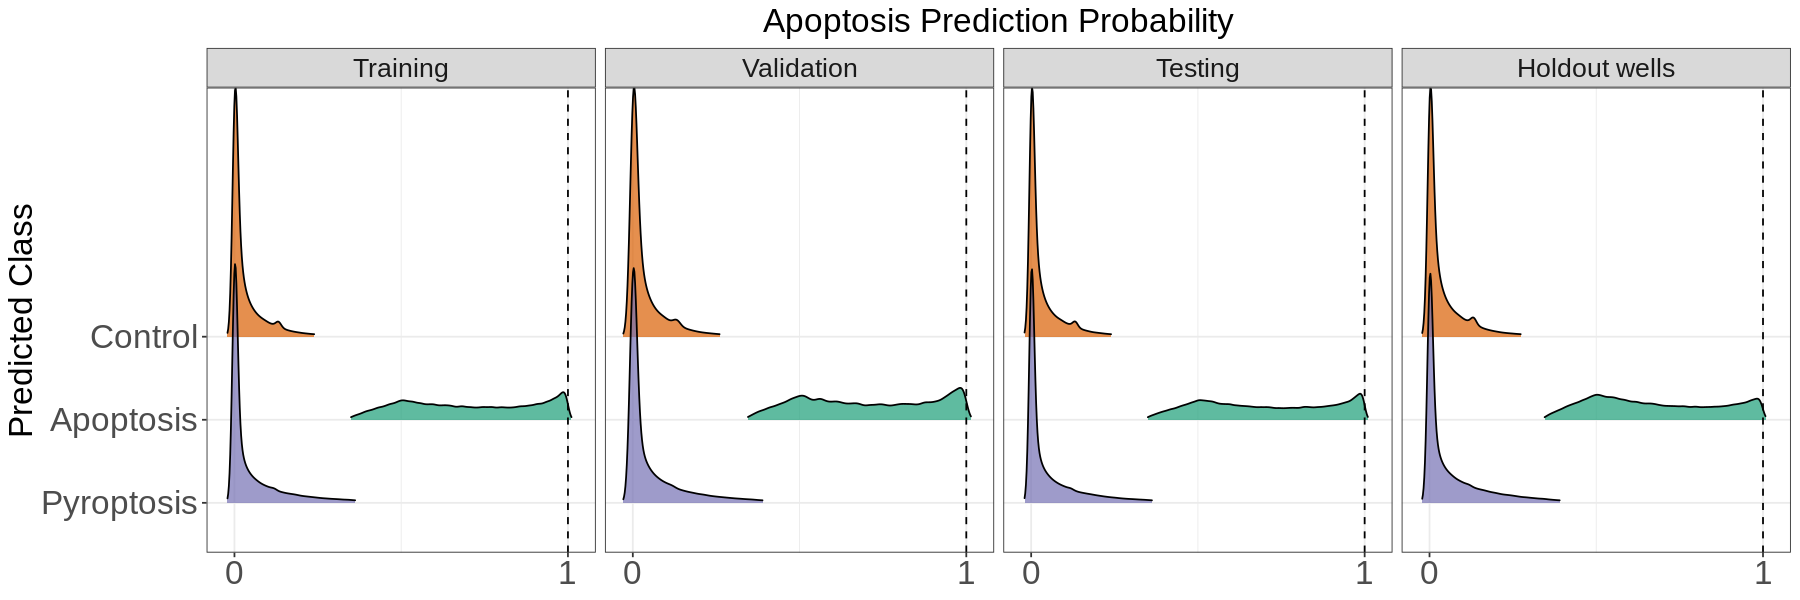

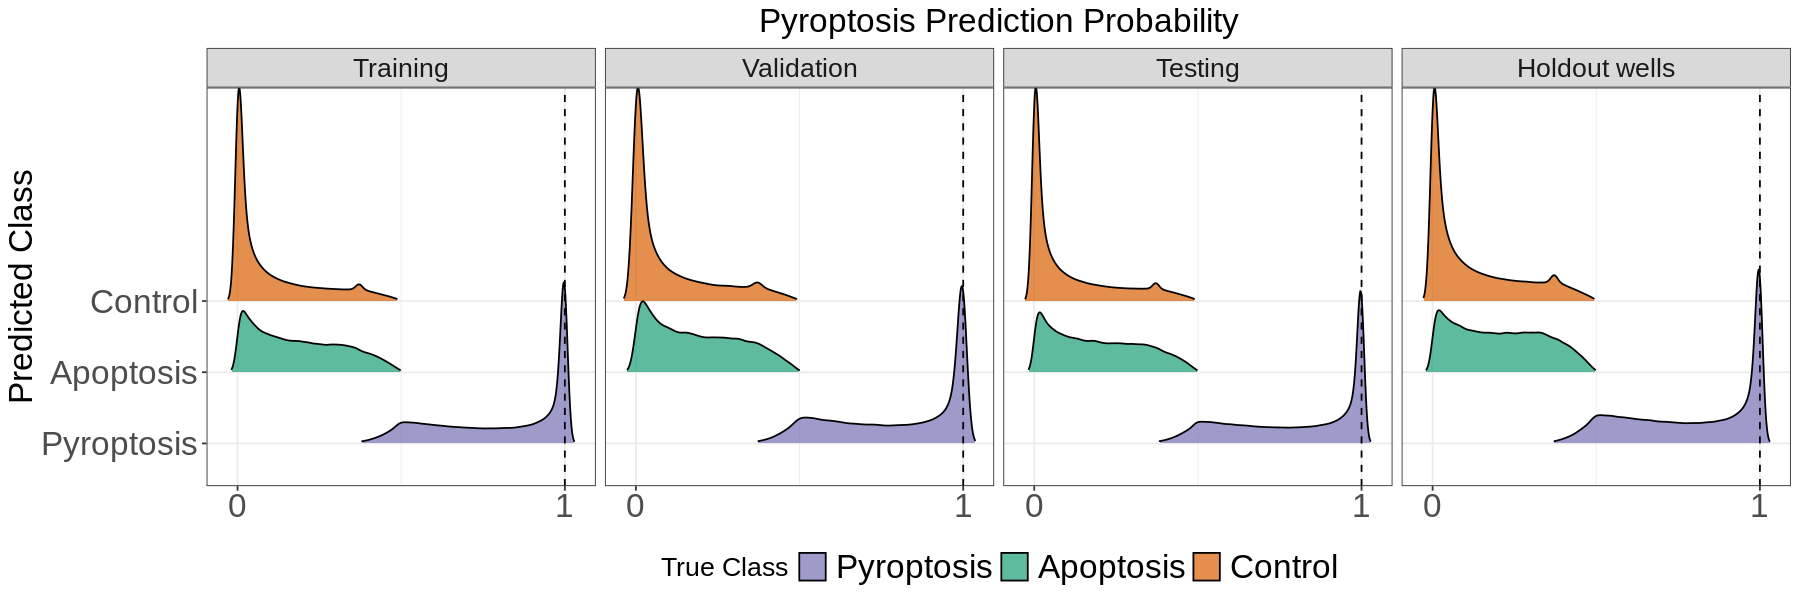

In [34]:
height <- 5
width <- 15
options(repr.plot.width = width, repr.plot.height = height)
ridge_plot_control <- (
    ggplot(probabilities, aes(x = control_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    # change color of the density ridges
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    

    + facet_grid(.~data_split, scales = "free_y")
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + scale_x_continuous(breaks = seq(0, ))
    + labs(title = "Control Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # no legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
)
ridge_plot_control


ridge_plot_apoptosis <- (
    ggplot(probabilities, aes(x = apoptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(.~data_split, scales = "free_y")
    + scale_x_continuous(breaks = seq(0, 1))
    + labs(title = "Apoptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    + theme(legend.position = "none")
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    # + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label   
    + theme(axis.title.x = element_blank())
)
ridge_plot_apoptosis

ridge_plot_pyroptosis <- (
    ggplot(probabilities, aes(x = pyroptosis_prob, y = label_pred, fill = label_true, group = label_pred))
    + geom_density_ridges(
        aes(fill = label_pred), alpha = 0.7, scale = 3, rel_min_height = 0.01
    )
    + scale_fill_manual(values = c(
        "Control" = brewer.pal(3, "Dark2")[2],
        "Apoptosis" = brewer.pal(3, "Dark2")[1],
        "Pyroptosis" = brewer.pal(3, "Dark2")[3]
    ))
    + geom_vline(xintercept = 1, linetype = "dashed", color = "black")
    + facet_grid(.~data_split, scales = "free_y")+ scale_x_continuous(breaks = seq(0, 1, 0.5))
    + scale_x_continuous(breaks = seq(0, 1))
    + labs(title = "Pyroptosis Prediction Probability", y = "Predicted Class",fill = "True Class")
    + labs()
    + theme_bw()
    + figure_theme
    # remove legend
    # + theme(legend.position = "none")
    # make title larger
    + theme(plot.title = element_text(size = 20, hjust = 0.5))
    + theme(legend.position = "bottom", legend.direction = "horizontal")
    # remove x axis label
    + theme(axis.title.x = element_blank())
    # add vertical line at 1 
)
ridge_plot_pyroptosis


In [35]:
# get the legend
legend <- get_legend(ridge_plot_pyroptosis)
ridge_plot_pyroptosis <- (
    # remove the legend
    ridge_plot_pyroptosis + theme(legend.position = "none")
)

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105

Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”


### Patch the individual facet grids together for a figure sub-panel

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00765

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0073

Picking joint bandwidth of 0.00799

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105



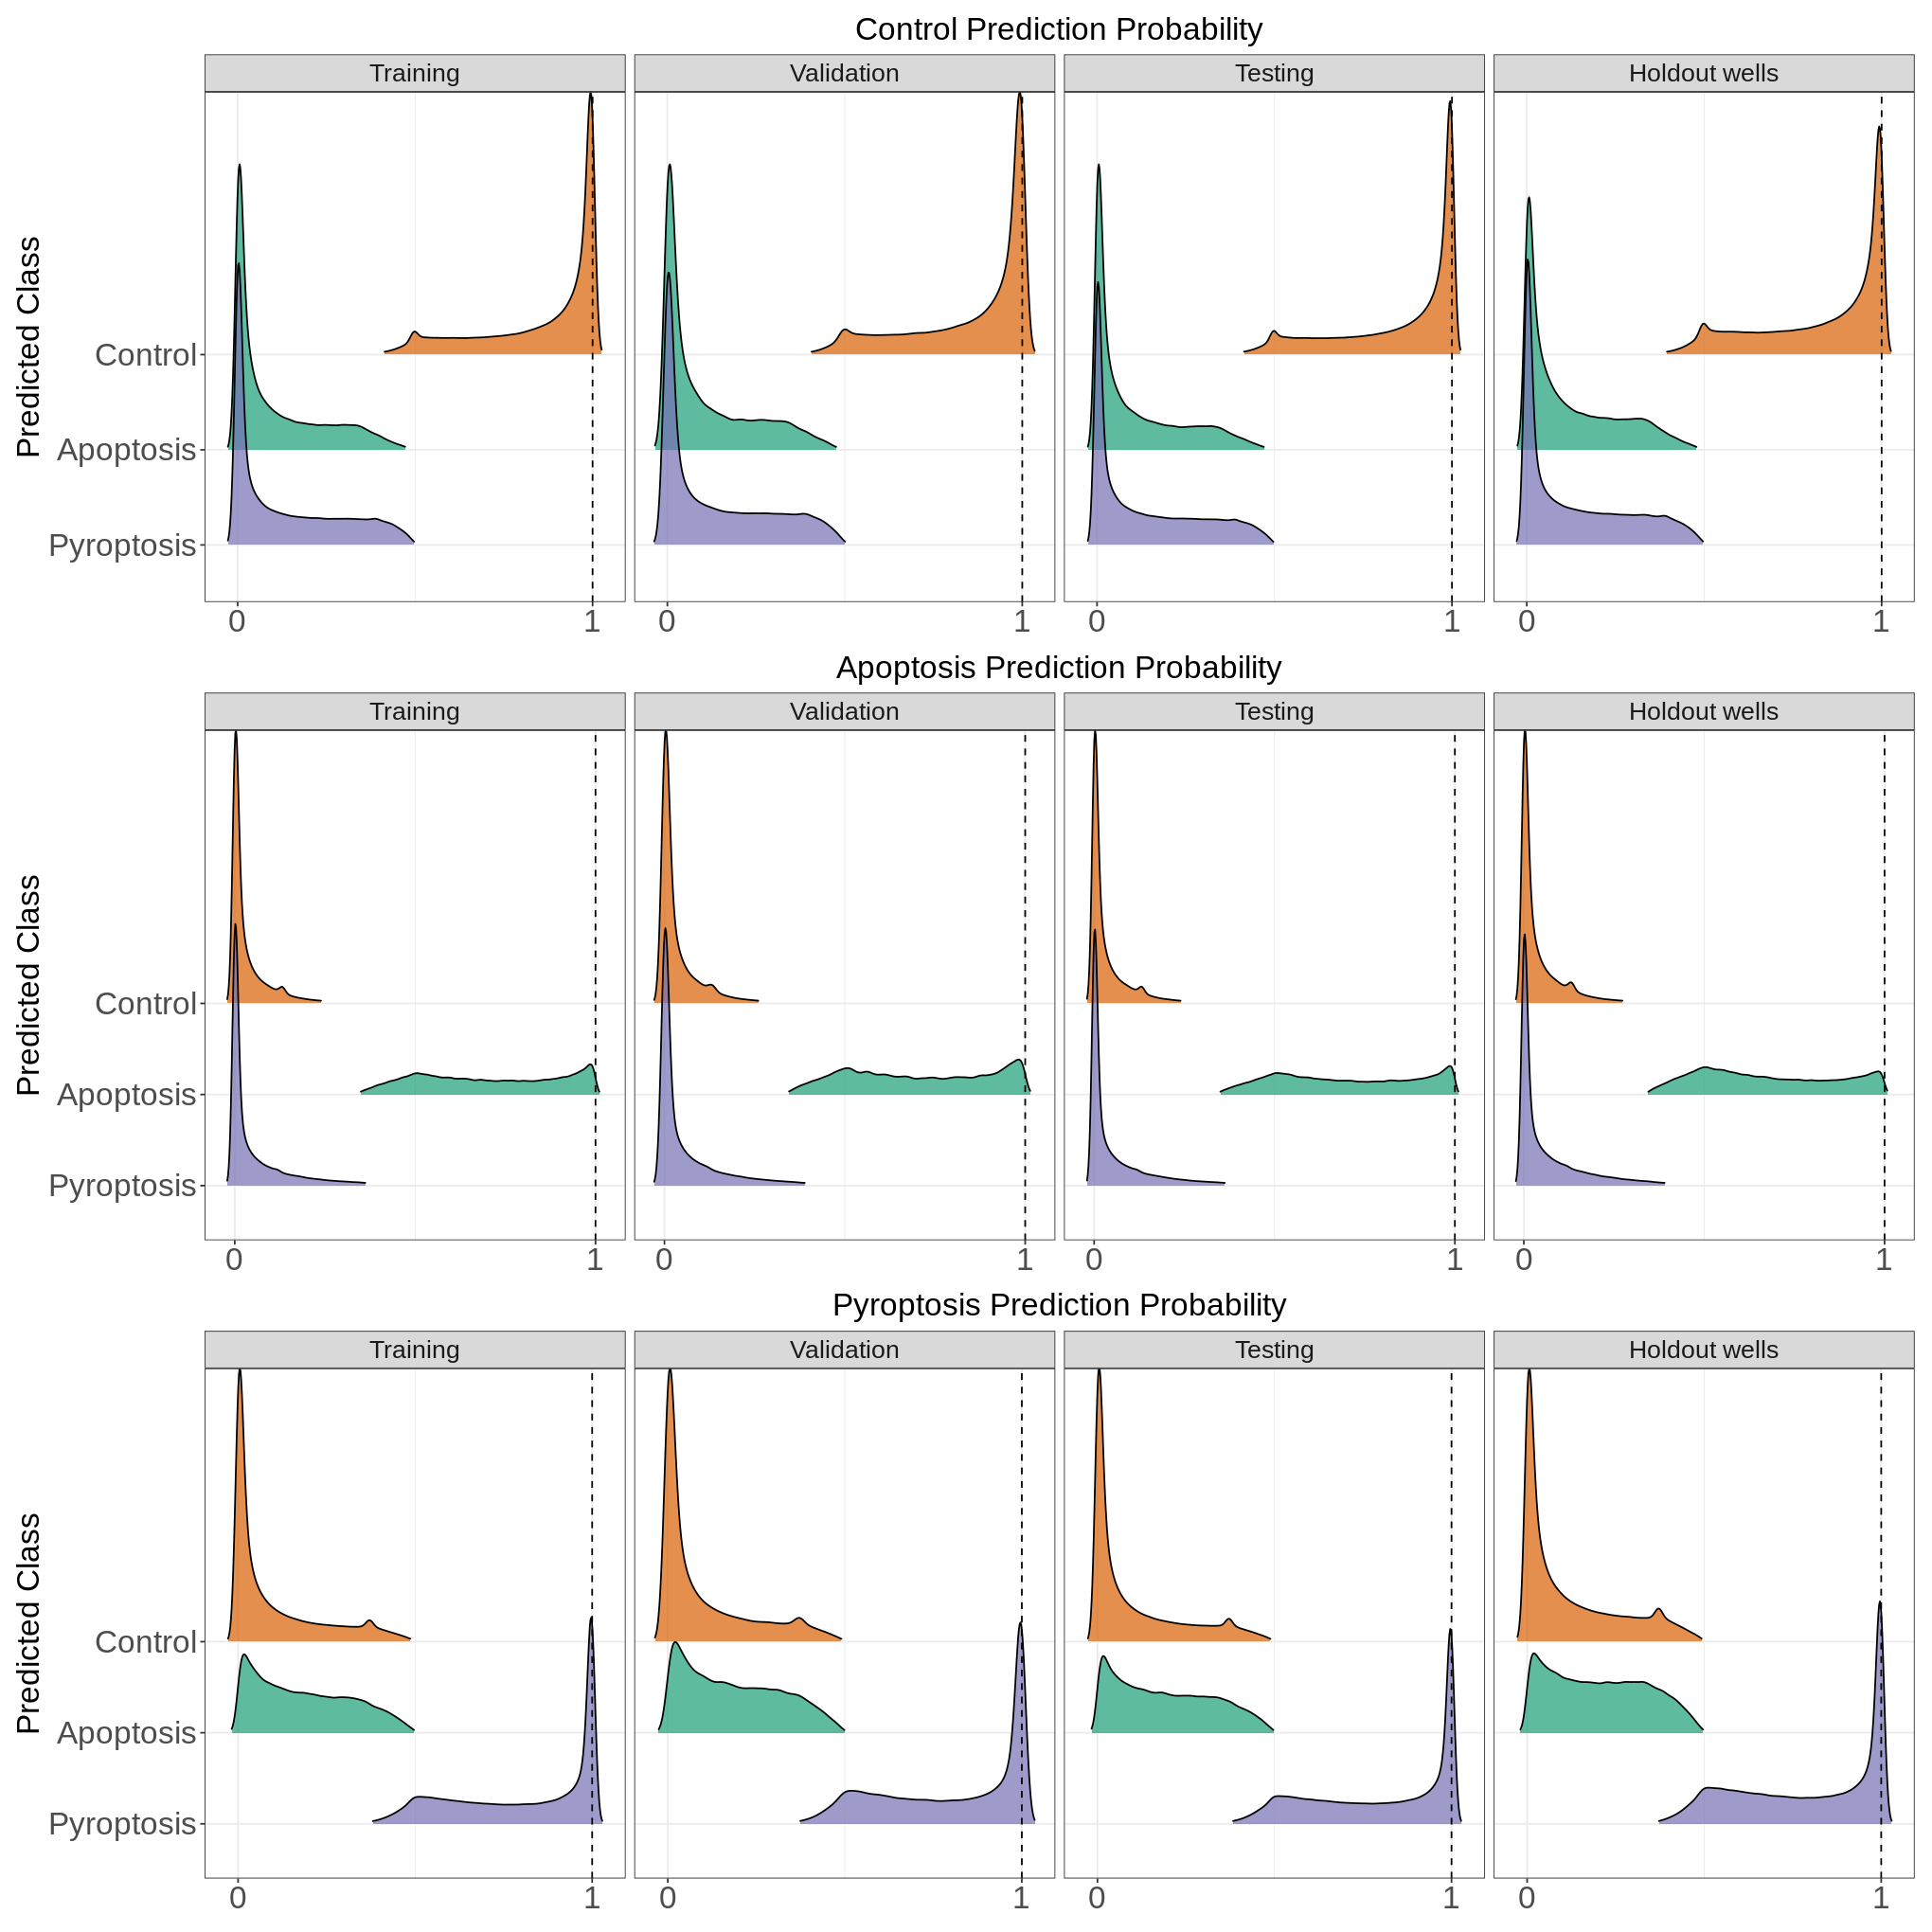

In [36]:
# ridge_plot_apoptosis
# ridge_plot_control
# ridge_plot_pyroptosis
# patch the plots together via the patchwork package
layout <- c(
    area(t=1, b=2, l=1, r=1), # A
    area(t=3, b=4, l=1, r=1), # B
    area(t=5, b=6, l=1, r=1)  # C
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5_probabilities <- (
    ridge_plot_control
    + ridge_plot_apoptosis
    + ridge_plot_pyroptosis
    + plot_layout(design = layout)
)
fig5_probabilities

## single cell predictions 

In [37]:
sc_preds_path <- file.path(
    paste0(
        "../../../8.cytopick_analysis/results/PBMC/single_cell_predictions.parquet"
    )
)
# read in the data from the parquet file
sc_preds <- arrow::read_parquet(
    sc_preds_path
)
head(sc_preds,2)


apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels,correct,image_path,image_crop_path
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
0.1279450,0.3454221,0.5266329,2,2,train,TRUE,pyroptosis,2021413,PBMC,⋯,1548.4671,1674,1563,1654,1535,10,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_cell_0.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_crop_cell_0.png
0.1557909,0.3331431,0.5110660,2,2,train,TRUE,pyroptosis,4926511,PBMC,⋯,596.1541,1090,606,1071,586,15,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_cell_1.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_shuffled_train_df_im1_im3_im4_composite_image_crop_cell_1.png


In [38]:
# define df subsets for each class, data split
pyroptosis_correct_train <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
pyroptosis_correct_validation <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
pyroptosis_correct_test <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
pyroptosis_correct_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]
pyroptosis_correct_treatment_holdout <- sc_preds[
    sc_preds$labels == "pyroptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "treatment_holdout",]

# repeat for apoptosis
apoptosis_correct_train <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
apoptosis_correct_validation <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
apoptosis_correct_test <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
apoptosis_correct_holdout <- sc_preds[
    sc_preds$labels == "apoptosis" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]

# repeat for control
control_correct_train <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "train",]
control_correct_validation <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "validation",]
control_correct_test <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "testing",]
control_correct_holdout <- sc_preds[
    sc_preds$labels == "healthy" & 
    sc_preds$correct == TRUE & 
    sc_preds$shuffle == FALSE &
    sc_preds$data_split == "holdout",]


# make a list of the data frames for each class
correct_class_dfs <- list(
    pyroptosis_correct_train,
    pyroptosis_correct_validation,
    pyroptosis_correct_test,
    pyroptosis_correct_holdout,
    pyroptosis_correct_treatment_holdout,

    apoptosis_correct_train,
    apoptosis_correct_validation,
    apoptosis_correct_test,
    apoptosis_correct_holdout,
    
    control_correct_train,
    control_correct_validation,
    control_correct_test,
    control_correct_holdout
)



In [39]:
pyroptosis_correct_train

apoptosis_prob,control_prob,pyroptosis_prob,label_true,label_pred,data_split,shuffle,class_name,index,Metadata_cell_type,⋯,Metadata_Nuclei_Location_Center_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMaximum_Y,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_X,Metadata_Cytoplasm_AreaShape_BoundingBoxMinimum_Y,Metadata_Site,labels,correct,image_path,image_crop_path
<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<chr>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>
1.233405e-09,4.133032e-09,1,2,2,train,FALSE,pyroptosis,3231695,PBMC,⋯,251.29504,596,270,558,238,4,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_0.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_0.png
5.051286e-10,1.496224e-08,1,2,2,train,FALSE,pyroptosis,740570,PBMC,⋯,307.49158,384,330,343,298,9,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_1.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_1.png
9.312168e-10,1.573694e-09,1,2,2,train,FALSE,pyroptosis,2577505,PBMC,⋯,1973.79369,1306,1985,1277,1954,14,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_2.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_2.png
5.601661e-10,1.849815e-08,1,2,2,train,FALSE,pyroptosis,7947702,PBMC,⋯,837.30278,1082,852,1057,827,12,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_3.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_3.png
5.068083e-08,3.672018e-11,1,2,2,train,FALSE,pyroptosis,2073460,PBMC,⋯,488.55460,444,501,418,475,12,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_4.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_4.png
1.309729e-09,1.220512e-10,1,2,2,train,FALSE,pyroptosis,405540,PBMC,⋯,73.16225,1461,83,1436,58,16,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_5.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_5.png
4.706153e-10,7.249056e-11,1,2,2,train,FALSE,pyroptosis,4923302,PBMC,⋯,1183.44277,1812,1195,1792,1174,14,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_6.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_crop_cell_6.png
3.515106e-09,6.607474e-10,1,2,2,train,FALSE,pyroptosis,2143605,PBMC,⋯,766.68481,1023,780,996,756,1,pyroptosis,TRUE,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_df_im1_im3_im4_composite_image_cell_7.png,/home/lippincm/Documents/4TB/data/Interstellar_Analysis/8.cytopick_analysis/figures/PBMC/pyroptosis_unshuffled_train_d

In [40]:
width <- 2
height <- 2
options(repr.plot.width = width, repr.plot.height = height)
# define function to return the image object
get_image <- function(df, i){
    # Load the PNG file
    img <- png::readPNG(df$image_crop_path[i])
    # Convert the image to a raster object
    g <- grid::rasterGrob(img, interpolate=TRUE)

    # Create a ggplot
    p <- ggplot() +
    annotation_custom(g, xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf) +
    theme_void()  # Remove axes and labels

    # Print the plot
    return(p)
}


In [41]:
pyroptosis_correct_train_image <- get_image(pyroptosis_correct_train, 4)
pyroptosis_correct_validation_image <- get_image(pyroptosis_correct_validation, 4)
pyroptosis_correct_test_image <- get_image(pyroptosis_correct_test, 4)
pyroptosis_correct_holdout_image <- get_image(pyroptosis_correct_holdout, 3)

control_correct_train_image <- get_image(control_correct_train, 2)
control_correct_validation_image <- get_image(control_correct_validation, 4)
control_correct_test_image <- get_image(control_correct_test, 4)
control_correct_holdout_image <- get_image(control_correct_holdout, 4)

apoptosis_correct_train_image <- get_image(apoptosis_correct_train, 4)
apoptosis_correct_validation_image <- get_image(apoptosis_correct_validation, 4)
apoptosis_correct_test_image <- get_image(apoptosis_correct_test, 4)
apoptosis_correct_holdout_image <- get_image(apoptosis_correct_holdout, 4)

# add titles to each image
pyroptosis_correct_train_image <- (
    pyroptosis_correct_train_image 
    + ggtitle("Pyroptosis\n(Train)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
pyroptosis_correct_validation_image <- (
    pyroptosis_correct_validation_image 
    + ggtitle("Pyroptosis\n(Validate)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

)
pyroptosis_correct_test_image <- (
    pyroptosis_correct_test_image 
    + ggtitle("Pyroptosis\n(Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

)
pyroptosis_correct_holdout_image <- (
    pyroptosis_correct_holdout_image 
    + ggtitle("Pyroptosis\n(Holdout wells)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

)

control_correct_train_image <- (
    control_correct_train_image 
    + ggtitle("Control\n(Train)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

)
control_correct_validation_image <- (
    control_correct_validation_image 
    + ggtitle("Control\n(Validate)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
control_correct_test_image <- (
    control_correct_test_image 
    + ggtitle("Control\n(Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
control_correct_holdout_image <- (
    control_correct_holdout_image 
    + ggtitle("Control\n(Holdout wells)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)

apoptosis_correct_train_image <- (
    apoptosis_correct_train_image 
    + ggtitle("Apoptosis\n(Train)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
apoptosis_correct_validation_image <- (
    apoptosis_correct_validation_image 
    + ggtitle("Apoptosis\n(Validate)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
apoptosis_correct_test_image <- (
    apoptosis_correct_test_image 
    + ggtitle("Apoptosis\n(Test)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)
apoptosis_correct_holdout_image <- (
    apoptosis_correct_holdout_image 
    + ggtitle("Apoptosis\n(Holdout wells)") 
    + theme(plot.title = element_text(size = 18, hjust = 0.5))
    + theme(plot.margin = margin(0, 0, 0, 0, "cm"))
)

# make a list of the images
correct_class_images <- list(
    pyroptosis_correct_train_image,
    pyroptosis_correct_validation_image,
    pyroptosis_correct_test_image,
    pyroptosis_correct_holdout_image,
    
    apoptosis_correct_train_image,
    apoptosis_correct_validation_image,
    apoptosis_correct_test_image,
    apoptosis_correct_holdout_image,
    
    control_correct_train_image,
    control_correct_validation_image,
    control_correct_test_image,
    control_correct_holdout_image
)


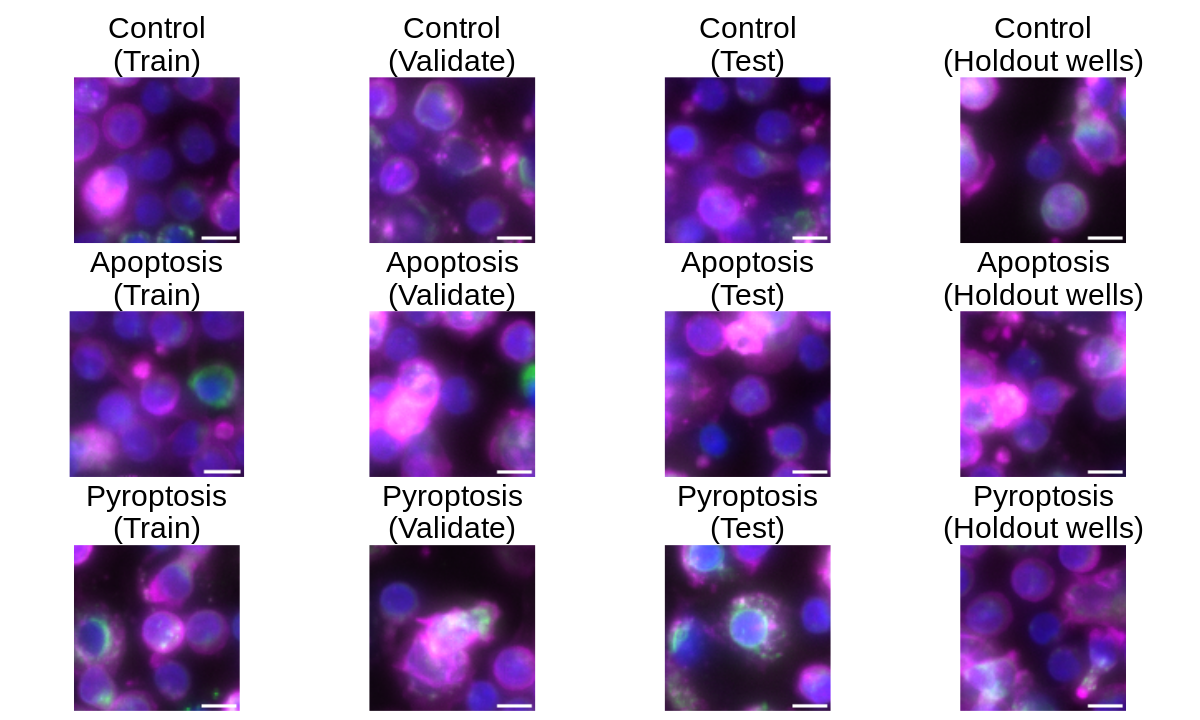

In [42]:
width <- 10
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
# stich the images together
correct_class_images <- (
    # plot image with 
    wrap_elements(full = control_correct_train_image)
    + wrap_elements(full = control_correct_validation_image)
    + wrap_elements(full = control_correct_test_image)
    + wrap_elements(full = control_correct_holdout_image)
    + wrap_elements(full = apoptosis_correct_train_image)
    + wrap_elements(full = apoptosis_correct_validation_image)
    + wrap_elements(full = apoptosis_correct_test_image)
    + wrap_elements(full = apoptosis_correct_holdout_image)
    + wrap_elements(full = pyroptosis_correct_train_image)
    + wrap_elements(full = pyroptosis_correct_validation_image)
    + wrap_elements(full = pyroptosis_correct_test_image)
    + wrap_elements(full = pyroptosis_correct_holdout_image)
    # + plot_layout(nrow = 2,widths = c(1,1,1), heights = c(1,1))
)
correct_class_images
# save the image
ggsave(
    file.path(
        paste0(
            "../figures/Multi_Class/",model_name,"/",cell_type,"/correct_class_images.png"
        )
    ),
    correct_class_images, width = width, height = height, dpi = 600
)

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105



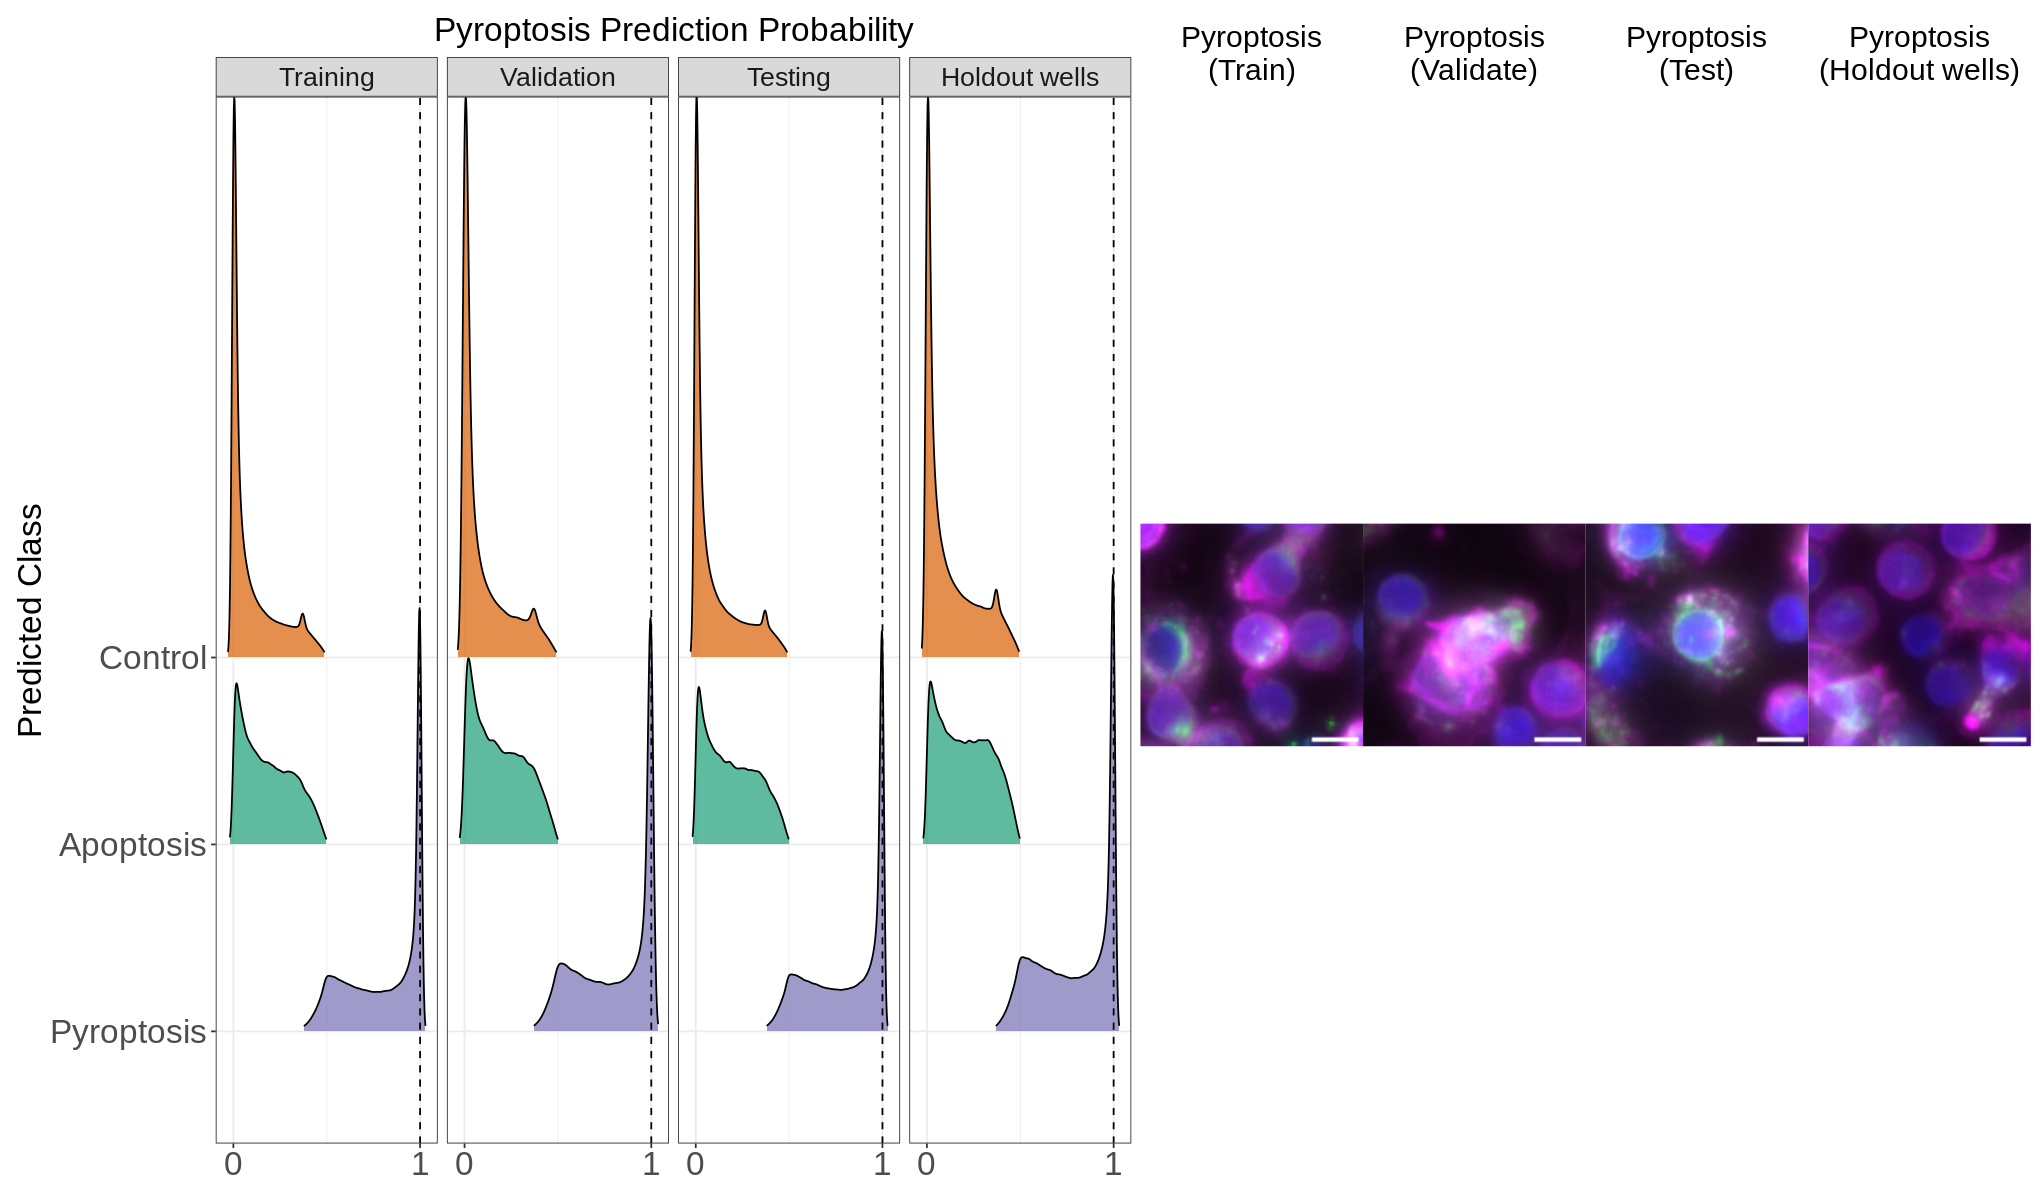

In [43]:
width <- 17
height <- 10
options(repr.plot.width = width, repr.plot.height = height)

layout <- c(
    # 1 row 5 columns with the first column being wider than the rest
    area(t=1, b=1, l=1, r=5), # A
    area(t=1, b=1, l=6, r=6), # B
    area(t=1, b=1, l=7, r=7), # C
    area(t=1, b=1, l=8, r=8), # D
    area(t=1, b=1, l=9, r=9) # E
)

# control correct train images + probabilties
control_correct_train_probabilities <- (

        wrap_elements(full = ridge_plot_control)
        + control_correct_train_image
        + control_correct_validation_image
        + control_correct_test_image
        + control_correct_holdout_image
    # + plot_layout(nrow =1 ,widths = c(2,1,1,1,1), heights = c(0.5,1,1,1,1))
    + plot_layout(design = layout)
)

apoptosis_correct_train_probabilities <- (
        wrap_elements(full = ridge_plot_apoptosis)
        + apoptosis_correct_train_image
        + apoptosis_correct_validation_image
        + apoptosis_correct_test_image
        + apoptosis_correct_holdout_image
    
    # + plot_layout(nrow =1 ,widths = c(2,1,1,1,1), heights = c(0.5,1,1,1,1))
    + plot_layout(design = layout)
)


# new layout for pyroptosis legend
layout <- c(
    # 1 row 5 columns with the first column being wider than the rest
    area(t=1, b=1, l=1, r=5), # A
    area(t=1, b=1, l=6, r=6), # B
    area(t=1, b=1, l=7, r=7), # C
    area(t=1, b=1, l=8, r=8), # D
    area(t=1, b=1, l=9, r=9) # E
)

pyroptosis_correct_train_probabilities <- (

        wrap_elements(full = ridge_plot_pyroptosis)
        + pyroptosis_correct_train_image
        + pyroptosis_correct_validation_image
        + pyroptosis_correct_test_image
        + pyroptosis_correct_holdout_image

    + plot_layout(design = layout)


    # add title 
    # + theme(plot.title = element_text(size = 20, hjust = 0.5))
)

pyroptosis_correct_train_probabilities 

### Patch the plots together

In [44]:
# convert each plot to a ggplot object
pr_plot <- as.grob(pr_plot)
confusion_matrix_plot <- as.grob(confusion_matrix_plot)
control_correct_train_probabilities <- as.grob(control_correct_train_probabilities)
apoptosis_correct_train_probabilities <- as.grob(apoptosis_correct_train_probabilities)
pyroptosis_correct_train_probabilities <- as.grob(pyroptosis_correct_train_probabilities)

Picking joint bandwidth of 0.00991

Picking joint bandwidth of 0.0131

Picking joint bandwidth of 0.00937

Picking joint bandwidth of 0.0101

Picking joint bandwidth of 0.00765

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0073

Picking joint bandwidth of 0.00799

Picking joint bandwidth of 0.0102

Picking joint bandwidth of 0.0135

Picking joint bandwidth of 0.00976

Picking joint bandwidth of 0.0105



png 
  2

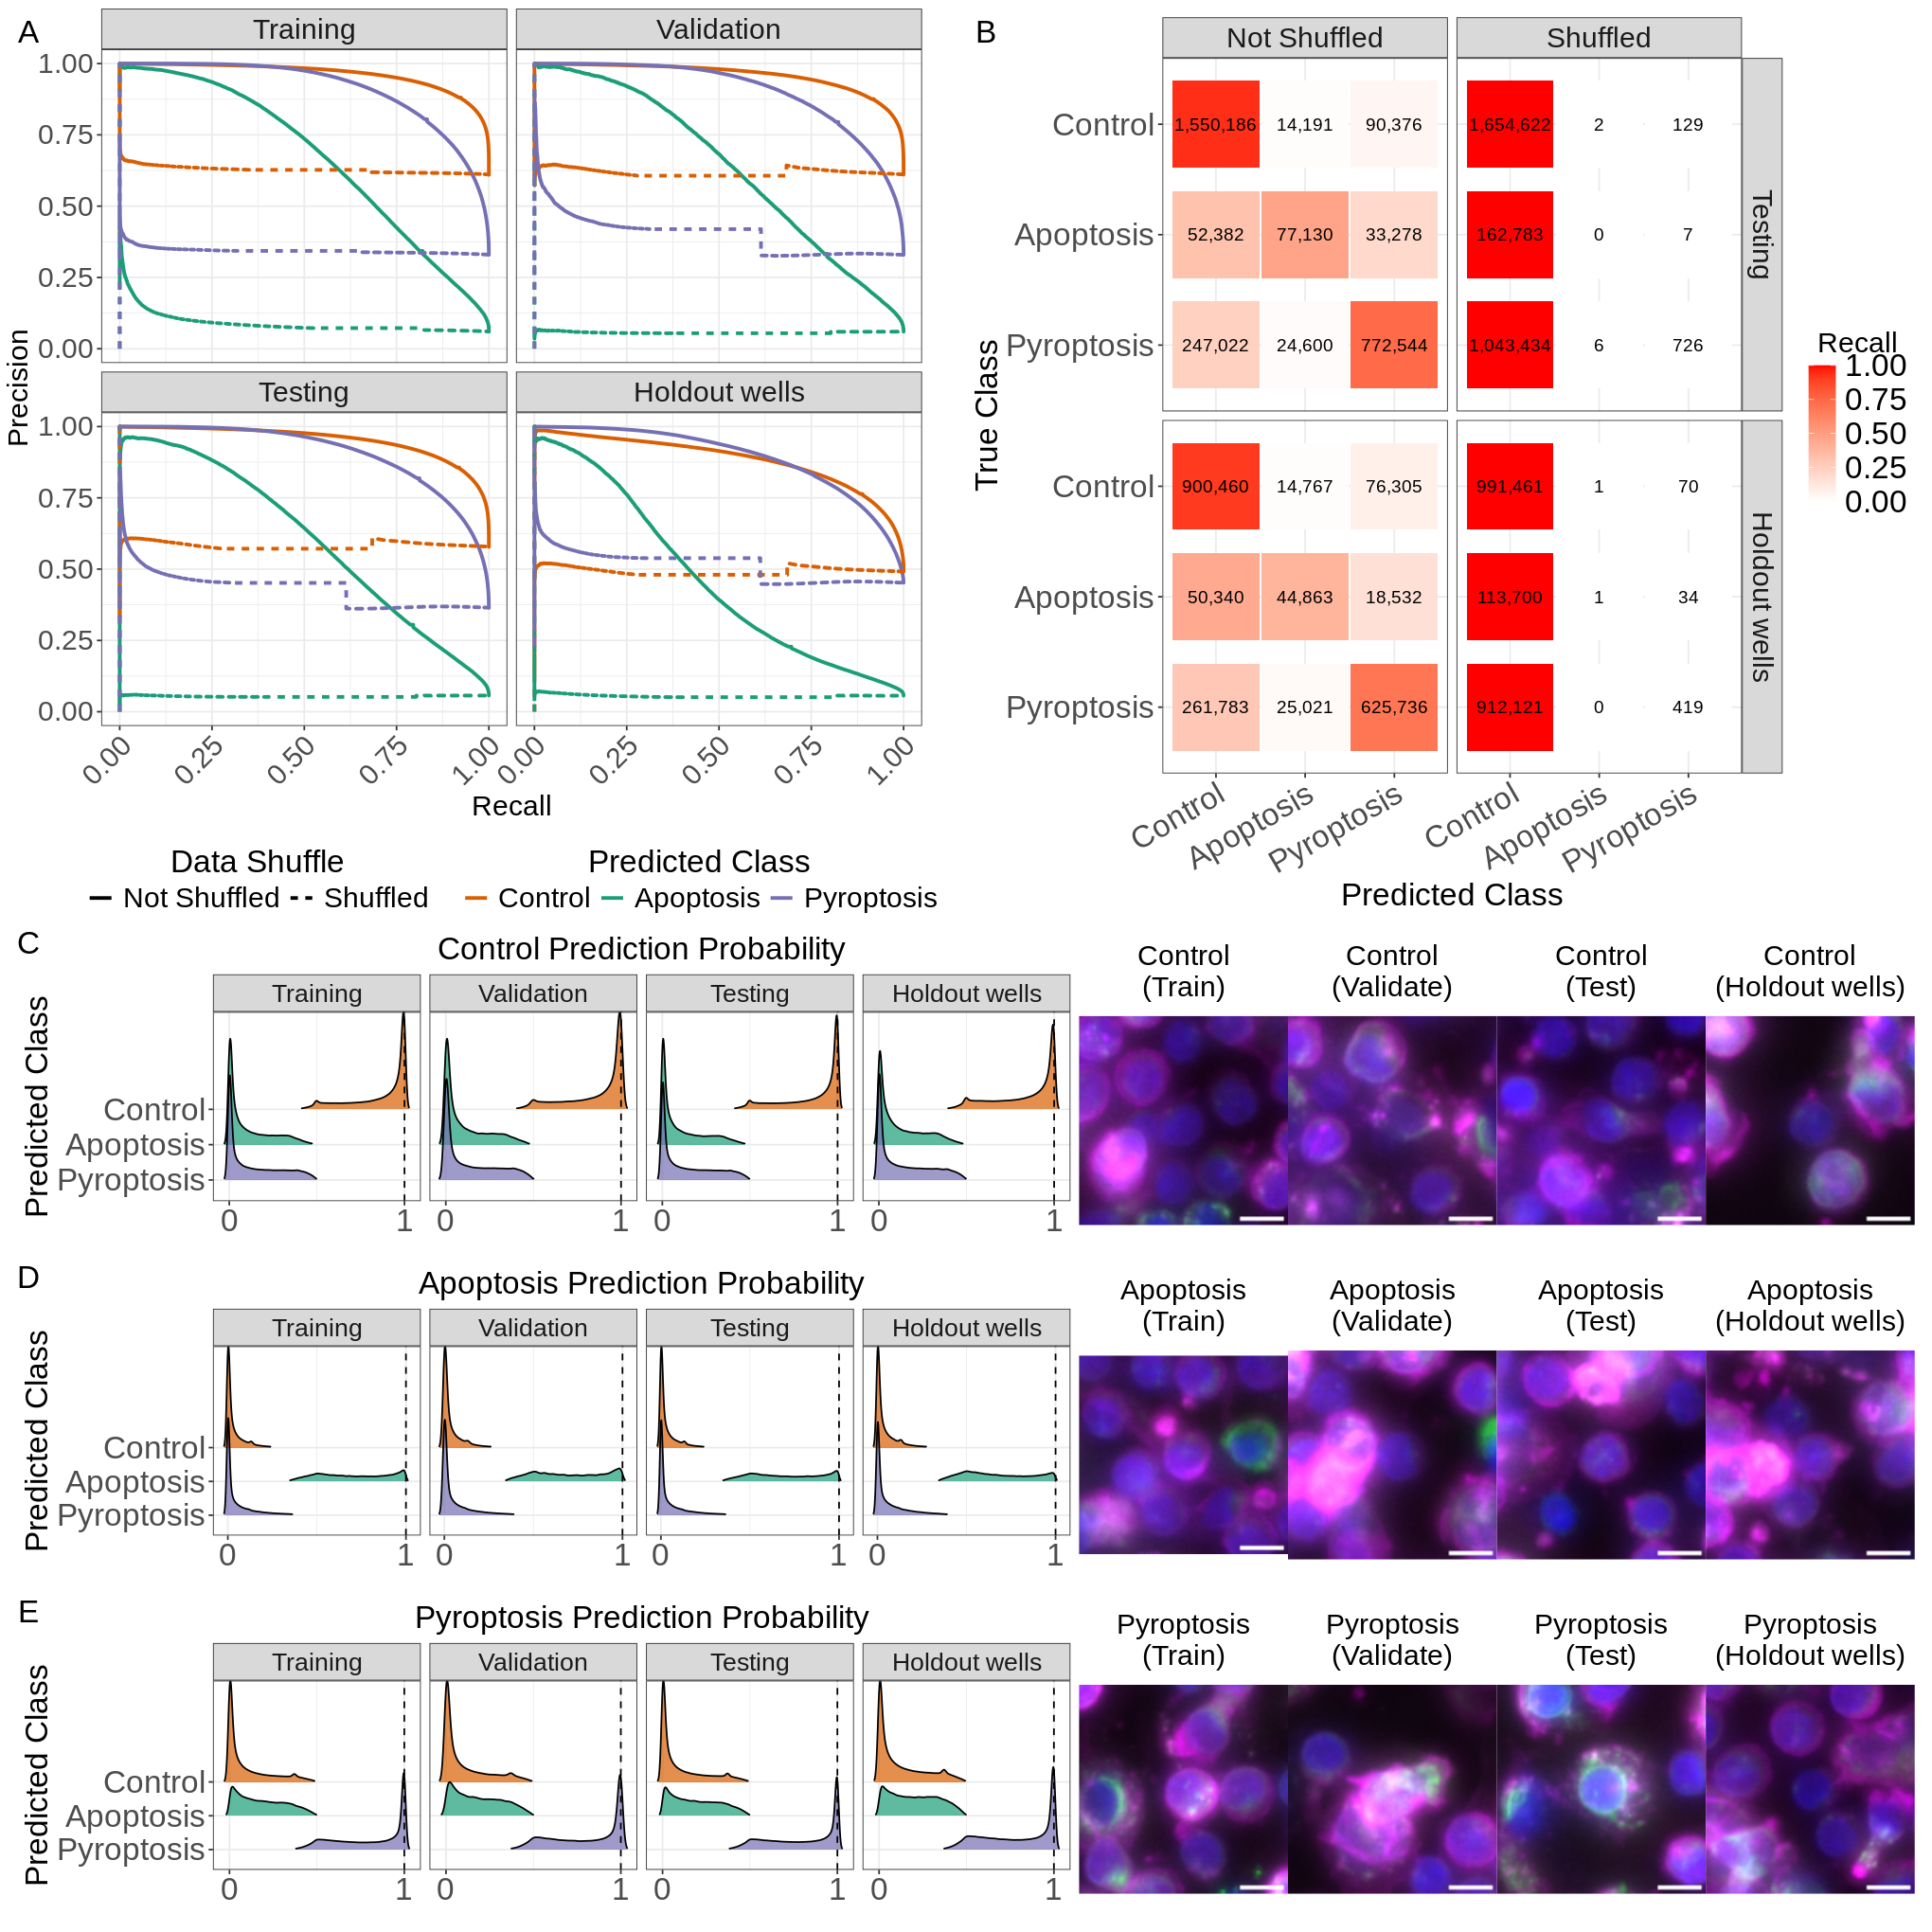

In [45]:
layout <- c(
    area(t=1, b=3, l=1, r=2), # A
    area(t=1, b=3, l=3, r=4), # B
    area(t=4, b=4, l=1, r=4), # C
    area(t=5, b=5, l=1, r=4), # D
    area(t=6, b=6, l=1, r=4) # E
)
# set plot size
width <- 17
height <- 17
options(repr.plot.width=width, repr.plot.height=height, units = "cm", dpi = 600)
fig5 <- (
    wrap_elements(full = pr_plot)
    + wrap_elements(full = confusion_matrix_plot)
    # + wrap_elements(full = fig5_probabilities)
    # + wrap_elements(full = correct_class_images)
    + wrap_elements(full = control_correct_train_probabilities)
    + wrap_elements(full = apoptosis_correct_train_probabilities)
    + wrap_elements(full = pyroptosis_correct_train_probabilities)
    
    
    # + fig5_probabilities
    + plot_layout(design = layout, widths = c(10, 10))
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 20))
)

# save the plot
png(filename = "../figures/figure5.png", width = width, height = height, units = "in", res = 600)
fig5
dev.off()
fig5